<a href="https://colab.research.google.com/github/vischia/ecai2025/blob/master/hello_uncertainty_quantification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Think Your Deep Learning Model Works? Think Again!!! — Hands-on (PyTorch)

## P. Vischia (pietro.vischia@cern.ch)

This tutorial assumes you have read [my Part 2 Lecture](https://www.hep.uniovi.es/vischia/persistent/2025-10-26_TutorialECAI2025.html), and possibly also [the lectures from Part 1 by Miriam](https://sites.google.com/view/dl-common-pitfalls/materials?authuser=0)

This tutorial demonstrates how:
- Building a small PyTorch model and **good vs bad** data splits
- **Deep ensembles** and a sketch of **temperature scaling**
- **Split Conformal Prediction** (CQR-style) for regression
- **Weighted Conformal** under covariate shift via a learned density ratio
- **OOD scoring** with **Energy** and **ODIN-style** perturbation
- **Regularization/model size sweep** to discuss double-descent-ish behavior
- **Demonstration of leakage in conformal prediction**
- A tiny example of **injecting inductive bias** (monotonicity penalty)
- A larger example of **injecting inductive bias**


In [7]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32) # if you are on Mac M1--4
torch.manual_seed(0)

# Small utility: simple training loop for MSE
def train_epoch_mse(model, opt, dl):
    model.train()
    for xb, yb in dl:
        opt.zero_grad()
        pred = model(xb)
        loss = F.mse_loss(pred, yb)
        loss.backward()
        opt.step()

def plot_hist(data, title, xlabel):
    plt.figure()
    plt.hist(data, bins=40)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.show()

def plot_hists(data, title, xlabel):
    plt.figure()
    for d, l in zip(data, title):
        plt.hist(d, bins=40, label=l)
    plt.legend(loc="best")
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.show()



## The Data

Let's start by creating a synthetic data set, made of:

- A training data set: $X \sim Gaus(0,1)$
- A test data set with a covariate shift: $X \sim Gaus(1.5,1)$
- A target label: $y = sin(x + \epsilon_1) + \epsilon_2$, with $\epsilon_1 < \epsilon_2$
- Group labels to illustrate leakage (e.g., sites/users): $randint(0,10)$

### Exercise
Play with the generated data set by changing its parameters and see how this affects everything that follows. For instance, try with $\epsilon_1 > \epsilon_2$, try with a larger or smaller covariate shift, try with a larger or smaller number of training events, and so on and so forth.

In [8]:
n = 6000 # Training events. Test events are 1/5 of those (usual 80/20 splitting)
x_train = torch.randn(n, 1)
y_train = (x_train + 0.3*torch.randn(n,1)).sin() + 0.1*torch.randn(n,1)

x_test  = torch.randn(n//5, 1) + 1.5
y_test  = (x_test + 0.3*torch.randn(n//5,1)).sin() + 0.1*torch.randn(n//5,1)

groups = torch.randint(0, 10, (n,))
groups_test = torch.randint(0, 10, (n//5,))

def get_loaders(x, y, batch=128, shuffle=True):
    ds = TensorDataset(x, y)
    return DataLoader(ds, batch_size=batch, shuffle=shuffle)


Now we want to try two ways of splitting the dataset.

Data leakage can happen when group-related features appear in both training and test sets. For instance, multiple data on a same patient (for instance multiple visits in time) must not be split among training and testing data set.

*Data Leakage is a huge problem for time series data*

You must take care that data related to the same group (e.g. a patient) appears *either* in the training set *or* the test set, but *not both*.

This kind of data leakage may lead to estimating the performance of the model too optimistically.

How to cope with this?
- The Bad Way: ignore the groups, and do the usual random shuffle. **this can cause leakage**
- The Good Way: hold out entire groups for either training or test data set

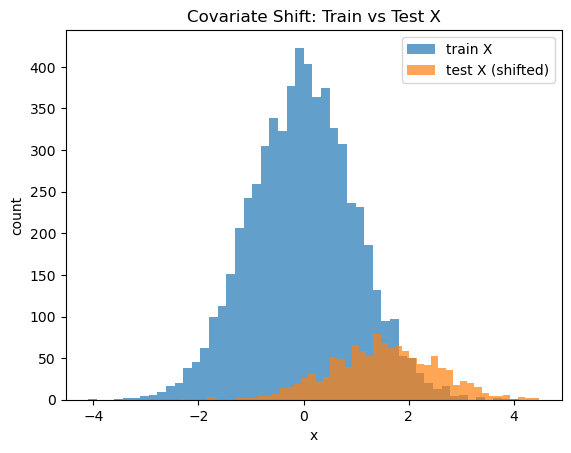

In [9]:
# BAD split: ignore groups, classical random shuffle-split (can leak)
bad_loader = get_loaders(x_train, y_train, shuffle=True)

# GOOD split exemplar: hold out entire groups -> emulate sklearn.GroupShuffleSplit
mask_holdout_groups = groups < 2  # groups {0,1} go to holdout
good_train_mask = ~mask_holdout_groups
dl_good = get_loaders(x_train[good_train_mask], y_train[good_train_mask], shuffle=True)

# Quick visualization of distributions
plt.figure()
plt.hist(x_train.numpy(), bins=50, alpha=0.7, label="train X")
plt.hist(x_test.numpy(), bins=50, alpha=0.7, label="test X (shifted)")
plt.legend()
plt.title("Covariate Shift: Train vs Test X")
plt.xlabel("x")
plt.ylabel("count")
plt.show()


## Deep Ensembles

As we saw in the slides, we want to build an ensembre of neural network.

Logically, we then start by defining a small Multilayer Perceptron class for regressing our data

In [10]:
class MLP(nn.Module):
    def __init__(self, d=1, h=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, 1)
        )
    def forward(self, x):
        return self.net(x)

def evaluate_mse(model, x, y):
    model.eval()
    with torch.no_grad():
        return F.mse_loss(model(x), y).item()

baseline = MLP()
opt = torch.optim.AdamW(baseline.parameters(), lr=1e-3, weight_decay=1e-4)
for _ in range(30):
    train_epoch_mse(baseline, opt, bad_loader)    # intentionally "bad" split to show optimism

mse_bad = evaluate_mse(baseline, x_test, y_test)
print("Baseline test MSE (bad split trained):", mse_bad)


Baseline test MSE (bad split trained): 0.047216758131980896


Now we are ready to do a Deep Ensemble (as in the slides, let's ensemble $5$ classifiers

### Exercise
Try using more classifiers, or less classifiers, and see how the reported uncertainty varies

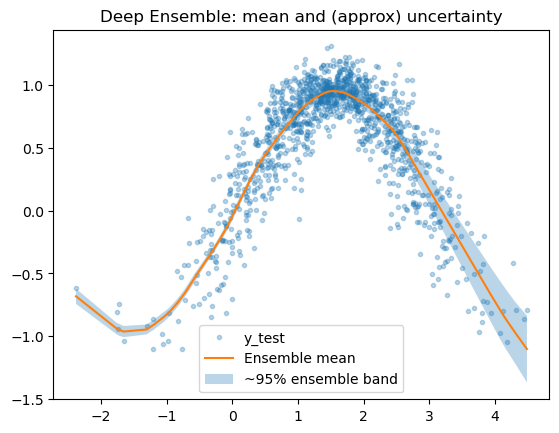

In [11]:
def fit_ensemble_member(seed, loader, epochs=30, h=64):
    torch.manual_seed(seed)
    m = MLP(h=h)
    opt = torch.optim.AdamW(m.parameters(), lr=1e-3, weight_decay=1e-4)
    for _ in range(epochs):
        train_epoch_mse(m, opt, loader)
    return m

E = [fit_ensemble_member(s, bad_loader) for s in range(5)]

@torch.no_grad()
def ens_predict(models, x):
    preds = torch.stack([m(x).squeeze(-1) for m in models], dim=0)  # [M, N]
    mean = preds.mean(0)
    var_epistemic = preds.var(0, unbiased=False)
    return mean, var_epistemic, preds

mu_bad, var_ep_bad, preds_bad = ens_predict(E, x_test)

# Plot predictive mean + a band from ensemble variance
plt.figure()
order = torch.argsort(x_test.squeeze(-1))
plt.plot(x_test[order].numpy(), y_test[order].numpy(), ".", alpha=0.3, label="y_test")
plt.plot(x_test[order].numpy(), mu_bad[order].unsqueeze(-1).numpy(), "-", label="Ensemble mean")
std = var_ep_bad.sqrt().unsqueeze(-1)
plt.fill_between(x_test[order].squeeze(-1).numpy(),
                 (mu_bad[order]-2*std[order].squeeze(-1)).numpy(),
                 (mu_bad[order]+2*std[order].squeeze(-1)).numpy(),
                 alpha=0.3, label="~95% ensemble band")
plt.title("Deep Ensemble: mean and (approx) uncertainty")
plt.legend()
plt.show()


### Temperature scaling

Reminder: temperature scaling consists in building a logistic regression on the logits and training it to output calibrated probabilities. This results in changing the *confidence* but *not the accuracy*, which remains constant.

### Exercise
- Use the sketch below of the TemperatureHead to retrain the DeepEnsemble.
- Then draw the reliability diagrams for the DeepEnsemble without temperature scaling and for the one with temperature scaling, and compare them
- Change the temperature and see how that affects the confidence (and verifies it does not change the accuracy)

In [12]:
# Temperature head sketch
    def __init__(self): 
        super().__init__()
        self.T = nn.Parameter(torch.ones(()))

def temp_scale(logits, T):
    return logits / T.clamp_min(1e-6)


IndentationError: unexpected indent (3990172891.py, line 2)

## Conformal prediction

We will now use Conformalized Quantile Qegression (CQR) to train a model to predict the lower and upper conditional quantiles and then calibrate the slack (the difference w.r.t. the target coverage)

We'll the print the nominal (target) coverage and the empirical coverage (to see if we over/under cover).

### Exercise
Play with the nominal coverage.
- Plot of empirical vs nominal coverage as a function of the nominal coverage
- Run many times to build the full distribution of the empirical coverage, and make an histogram of it, with a vertical line indicating the nominal coverage. See if you get a distribution similar to that in Slide 36.

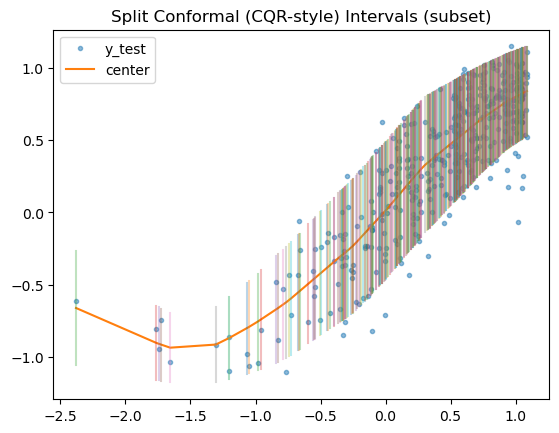

Approx. marginal coverage on shifted test (nominal 0.9): 0.923


In [13]:
# Make a proper split for conformal: train/calibration (no peeking)
idx = torch.randperm(len(x_train))
n_cal = len(x_train)//5
idx_cal, idx_tr = idx[:n_cal], idx[n_cal:]
x_tr, y_tr = x_train[idx_tr], y_train[idx_tr]
x_cal, y_cal = x_train[idx_cal], y_train[idx_cal]

def get_loader_xy(x, y, batch=128, shuffle=True):
    return DataLoader(TensorDataset(x, y), batch_size=batch, shuffle=shuffle)

dl_tr = get_loader_xy(x_tr, y_tr)

# Quantile model
class QuantileMLP(nn.Module):
    def __init__(self, d=1, h=64):
        super().__init__()
        self.f = nn.Sequential(nn.Linear(d,h), nn.ReLU(), nn.Linear(h,h), nn.ReLU())
        self.q_lo = nn.Linear(h,1)  # tau=0.1
        self.q_hi = nn.Linear(h,1)  # tau=0.9
    def forward(self, x):
        h = self.f(x)
        return self.q_lo(h), self.q_hi(h)

def pinball(yhat, y, q):
    e = y - yhat
    return torch.mean(torch.maximum(q*e, (q-1)*e))

qnet = QuantileMLP()
optq = torch.optim.Adam(qnet.parameters(), lr=1e-3)
for epoch in range(40):
    for xb, yb in dl_tr:
        optq.zero_grad()
        ql, qh = qnet(xb)
        loss = pinball(ql, yb, 0.1) + pinball(qh, yb, 0.9)
        loss.backward()
        optq.step()

@torch.no_grad()
def predict_q(x):
    ql, qh = qnet(x)
    return ql.squeeze(-1), qh.squeeze(-1)

@torch.no_grad()
def cqr_intervals(x_new, alpha=0.1):
    ql, qh = predict_q(x_cal)
    s = torch.maximum(ql - y_cal.squeeze(-1), y_cal.squeeze(-1) - qh)   # CQR score
    qhat = torch.quantile(s, 1 - alpha, interpolation='higher')
    ql_new, qh_new = predict_q(x_new)
    return (ql_new - qhat, qh_new + qhat)

L, U = cqr_intervals(x_test, alpha=0.1)

# Visualize intervals on a subset
idx_plot = torch.argsort(x_test.squeeze(-1))[:400]
xp, yp = x_test[idx_plot], y_test[idx_plot]
Lp, Up = L[idx_plot], U[idx_plot]

plt.figure()
plt.plot(xp.numpy(), yp.numpy(), ".", alpha=0.5, label="y_test")
plt.plot(xp.numpy(), ((Lp+Up)/2).unsqueeze(-1).numpy(), "-", label="center")
for i in range(len(xp)):
    plt.plot([xp[i].item(), xp[i].item()], [Lp[i].item(), Up[i].item()], alpha=0.3)
plt.title("Split Conformal (CQR-style) Intervals (subset)")
plt.legend()
plt.show()

@torch.no_grad()
def coverage(y_true, L, U):
    return ((y_true.squeeze(-1) >= L) & (y_true.squeeze(-1) <= U)).float().mean().item()

cov = coverage(y_test, L, U)
print("Approx. marginal coverage on shifted test (nominal 0.9):", round(cov, 3))


## Conformal prediction under covariate shift

Reminder: we will want to upweight the conformal scores from calibration points that would be more likely under the new distribution, using the weight:

$w(x)=\frac{dP\_{test}(x)}{dP/(x)}$

and then we will use the weighted quantile.

### Exercise
- Compare the weighted coverage with the nonweighted coverage (the one that doesn't account for the covariate shift)
- Change the definition of the weight and watch the world crumble

In [14]:
from torch.utils.data import DataLoader

x_p = x_cal                       # calibration features from P
x_q = x_test                      # test covariates from Q (assume available at calibration)
Xp = torch.cat([x_p, x_q], dim=0)
y_domain = torch.cat([torch.zeros(len(x_p)), torch.ones(len(x_q))]).long()

dom_net = nn.Sequential(nn.Linear(1,32), nn.ReLU(), nn.Linear(32,2))
optD = torch.optim.Adam(dom_net.parameters(), lr=1e-3)

dlD = DataLoader(TensorDataset(Xp, y_domain), batch_size=128, shuffle=True)
for _ in range(20):
    for xb, yb in dlD:
        optD.zero_grad()
        logits = dom_net(xb)
        loss = F.cross_entropy(logits, yb)
        loss.backward()
        optD.step()

@torch.no_grad()
def density_ratio(x):
    logits = dom_net(x)
    p = F.softmax(logits, dim=-1)
    p_q = p[:,1]
    p_p = p[:,0]
    ratio = (p_q / p_p).clamp(1e-3, 1e3)
    return ratio

@torch.no_grad()
def weighted_cqr_intervals(x_new, alpha=0.1):
    ql, qh = predict_q(x_cal)
    s = torch.maximum(ql - y_cal.squeeze(-1), y_cal.squeeze(-1) - qh)
    w = density_ratio(x_cal)
    w = w / w.sum()
    s_sorted, idx = torch.sort(s)
    w_sorted = w[idx]
    cdf = torch.cumsum(w_sorted, dim=0)
    pos = (cdf >= 1 - alpha).nonzero()[0]
    qhat = s_sorted[pos]
    ql_new, qh_new = predict_q(x_new)
    return (ql_new - qhat, qh_new + qhat)

Lw, Uw = weighted_cqr_intervals(x_test, alpha=0.1)

cov_w = coverage(y_test, Lw, Uw)
print("Weighted CP coverage on shifted test (nominal 0.9):", round(cov_w, 3))

# Compare interval widths
width_std = (U - L).mean().item()
width_w   = (Uw - Lw).mean().item()
print("Avg width (Standard CP):", round(width_std, 3))
print("Avg width (Weighted CP):", round(width_w, 3))


Weighted CP coverage on shifted test (nominal 0.9): 0.904
Avg width (Standard CP): 0.707
Avg width (Weighted CP): 0.673


## Out of Distribution (OOD) Shenanigans

We'll apply two OOD detection algorithms: ODIN and the Energy one.

We start with a small classifier for our synthetic regression labels.

In [15]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1,64), nn.ReLU(), nn.Linear(64,2))
    def forward(self, x): return self.net(x)

clf = Classifier()
optC = torch.optim.AdamW(clf.parameters(), lr=5e-4)
y_cls = (y_train.squeeze(-1) > 0).long()
dl_cls = DataLoader(TensorDataset(x_train, y_cls), batch_size=128, shuffle=True)

for _ in range(25):
    for xb, yb in dl_cls:
        optC.zero_grad()
        logits = clf(xb)
        loss = F.cross_entropy(logits, yb)
        loss.backward()
        optC.step()


Now we are ready to calculate the Energy and ODIN OOD detectors

### Exercise
Play with the temperature

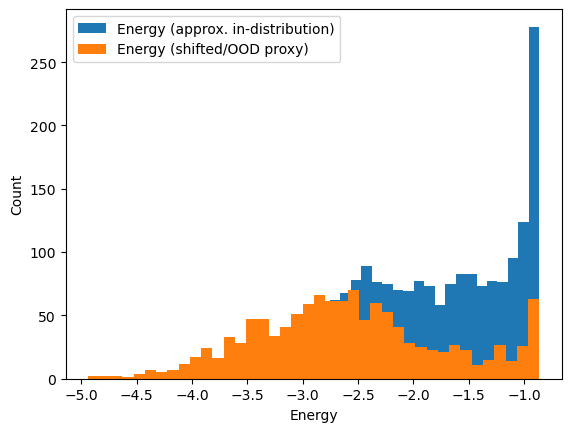

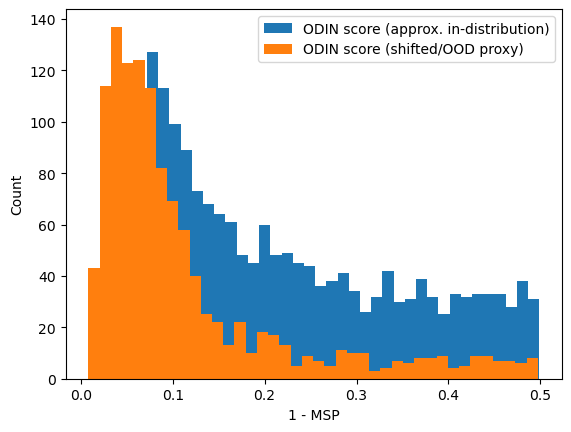

In [16]:
@torch.no_grad()
def energy_score(x):
    logits = clf(x)
    return -torch.logsumexp(logits, dim=-1)

E_in  = energy_score(x_train[:2000]).numpy()
E_ood = energy_score(x_test[:2000]).numpy()

plot_hists([E_in, E_ood], ["Energy (approx. in-distribution)","Energy (shifted/OOD proxy)"], "Energy")

# ODIN-style: temperature + small input perturbation
def odin_score(x, eps=0.001, T=2.0):
    x = x.clone().detach().requires_grad_(True)
    logits = clf(x)/T
    yhat = logits.argmax(dim=-1)
    loss = F.cross_entropy(logits, yhat)
    loss.backward()
    x_pert = x - eps * x.grad.sign()
    with torch.no_grad():
        logits_p = clf(x_pert)/T
        msp = F.softmax(logits_p, dim=-1).max(dim=-1).values
    return 1 - msp  # larger => more likely OOD

ODIN_in  = odin_score(x_train[:2000]).detach().numpy()
ODIN_ood = odin_score(x_test[:2000]).detach().numpy()

plot_hists([ODIN_in, ODIN_ood], ["ODIN score (approx. in-distribution)","ODIN score (shifted/OOD proxy)"], "1 - MSP")

## Regularization and model size sweep
### (a vulgar attempt at reproducing the double-descent behaviour)

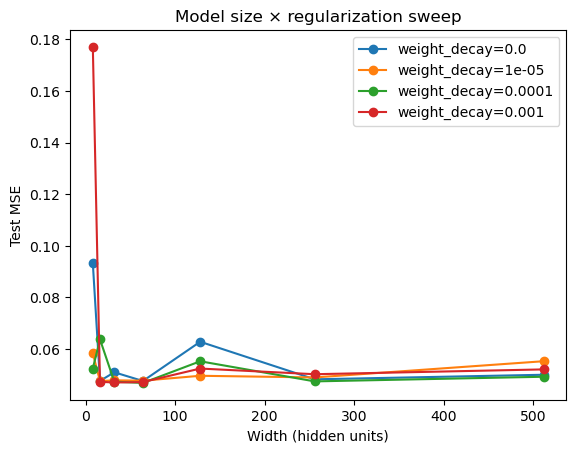

In [17]:
def train_and_eval(width, wd, epochs=60):
    m = MLP(h=width)
    opt = torch.optim.AdamW(m.parameters(), lr=1e-3, weight_decay=wd)
    for _ in range(epochs):
        train_epoch_mse(m, opt, dl_good)   # use "good" split now
    with torch.no_grad():
        mse = F.mse_loss(m(x_test), y_test).item()
    return mse

widths = [8, 16, 32, 64, 128, 256, 512]
wds    = [0.0, 1e-5, 1e-4, 1e-3]
results = np.zeros((len(wds), len(widths)))

for i, wd in enumerate(wds):
    for j, w in enumerate(widths):
        results[i, j] = train_and_eval(w, wd)

# Plot: one figure with lines for each weight decay over width
plt.figure()
for i, wd in enumerate(wds):
    plt.plot(widths, results[i], marker="o", label=f"weight_decay={wd}")
plt.xlabel("Width (hidden units)")
plt.ylabel("Test MSE")
plt.title("Model size × regularization sweep")
plt.legend()
plt.show()


## Leakage and validity of conformal prediction

*DO NOT DO THIS AT HOME: IT IS WRONG, WE DO IT HERE ONLY TO ILLUSTRATE HOW BAD IT IS:* We'll calculate conformal prediction intervals using the test distribution in calibration, and compare to what happens when we properly compute the conformal prediction intervals strictly from the training distribution

Coverage (BAD split / leakage): 0.923
Coverage (GOOD split):           0.31


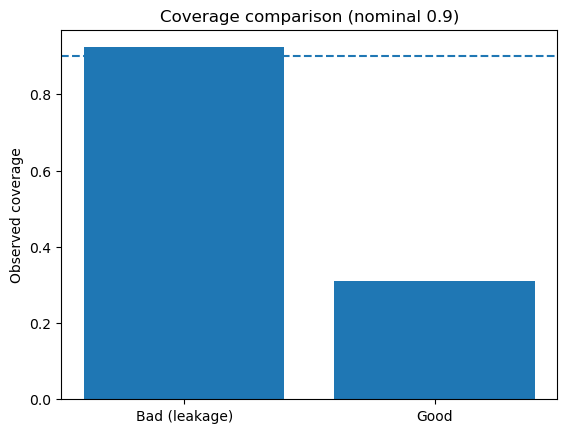

In [18]:
# BAD: DO NOT DO THIS EVER
Lb, Ub = cqr_intervals(x_test, alpha=0.1)  # wrong: calibration polluted by test covariates
cov_bad = coverage(y_test, Lb, Ub)

# GOOD: DO THIS INSTEAD
Lg, Ug = cqr_intervals(x_train[idx_cal][:len(x_test)], alpha=0.1) # Only training events are used
cov_good = coverage(y_test, Lg, Ug)

print("Coverage (BAD split / leakage):", round(cov_bad, 3))
print("Coverage (GOOD split):          ", round(cov_good, 3))

# Plot bar comparison
plt.figure()
plt.bar(["Bad (leakage)", "Good"], [cov_bad, cov_good])
plt.axhline(0.9, linestyle="--")
plt.title("Coverage comparison (nominal 0.9)")
plt.ylabel("Observed coverage")
plt.show()


## Simple inductive bias: a monotonicity penalty

We'll introduce a monotonic penalty, and see how it changes the prediction from our basic MLP

### Exercise
- Play with the strength of the penalty (the `1e-2`) to stronger and weaker values
- Change the initial dataset playing with its parameters and entity of covariate shift

Test MSE with monotonicity penalty: 0.0479


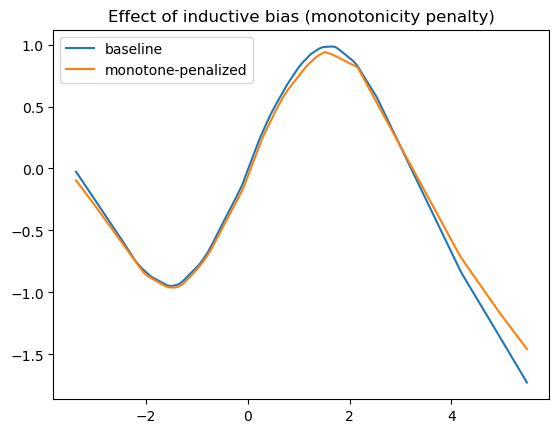

In [19]:
def monotone_penalty(model, xs):
    xs = xs.clone().detach().requires_grad_(True)
    y = model(xs)
    grad = torch.autograd.grad(y.sum(), xs, create_graph=True)[0]
    return F.relu(-grad).mean()

m_mono = MLP()
opt_mono = torch.optim.AdamW(m_mono.parameters(), lr=1e-3, weight_decay=1e-4)
for _ in range(30):
    for xb, yb in dl_good:
        opt_mono.zero_grad()
        pred = m_mono(xb)
        loss = F.mse_loss(pred, yb) + 1e-2 * monotone_penalty(m_mono, xb)
        loss.backward()
        opt_mono.step()

mse_mono = evaluate_mse(m_mono, x_test, y_test)
print("Test MSE with monotonicity penalty:", round(mse_mono, 4))

# Visualize predictions vs baseline at a grid
grid = torch.linspace(x_test.min().item()-1, x_test.max().item()+1, 400).unsqueeze(-1)
with torch.no_grad():
    y_base = baseline(grid)
    y_mono = m_mono(grid)

plt.figure()
plt.plot(grid.numpy(), y_base.numpy(), label="baseline")
plt.plot(grid.numpy(), y_mono.numpy(), label="monotone-penalized")
plt.title("Effect of inductive bias (monotonicity penalty)")
plt.legend()
plt.show()


## Inductive bias in a real case

Implement the inductive bias we used for this paper [Phys. Rev. D 110, 096023](https://doi.org/10.1103/PhysRevD.110.096023).

How? We have put the code freely online: [https://github.com/sscruz/eq_CP/](https://github.com/sscruz/eq_CP/)!!!

We want to enforce equivariance with respect to a symmetry called Charge-Parity (CP).

- We write down the most general equivariant function under CP:
    $f(event) = g(event) - g(CP(event))$
- We parameterize $g$ using a neural network, then train $f$ to minimize a loss function
  - After training score is CP-odd (even) for CP-odd (even) processes
- Injected information results in <b>40-300% less iterations</b> needed to achieve the same loss value!!!

It's very simple!

We define a `self.main_module` that is a regular sequential model (MLP), and instead of returning `self.main_module(x)` we simply return `self.main_module(x)-self.main_module(cpx)`, where `cpx` is the data point transformed according to the CP symmetry.


## Have fun, and have a great ECAI 2025!!!

We will :D